In [1]:
from scapy.all import * # Packet manipulation
import pandas as pd # Pandas - Create and Manipulate DataFrames
import numpy as np # Math Stuff (don't worry only used for one line :] )
import binascii # Binary to Ascii 
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

In [2]:
df = pd.read_csv('analisis_paquetes.csv')
df.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,10.1.10.53,84.54.22.33,DNS,975,Standard query 0x000c AAAA google.com
1,2,0.032433,84.54.22.33,10.1.10.53,DNS,98,Standard query response 0x000c AAAA google.com...
2,3,1.020103,10.1.10.53,84.54.22.33,DNS,989,Standard query 0x000c AAAA google.com
3,4,1.038961,84.54.22.33,10.1.10.53,DNS,98,Standard query response 0x000c AAAA google.com...
4,5,2.042830,10.1.10.53,84.54.22.33,DNS,1026,Standard query 0x000c AAAA google.com


Captura de 10 paquetes

In [3]:
num_of_packets_to_sniff = 10
pcap = sniff(count=num_of_packets_to_sniff)

# rdpcap returns packet list
## packetlist object can be enumerated 
print(type(pcap))
print(len(pcap))
print(pcap)
pcap[0]

<class 'scapy.plist.PacketList'>
10
<Sniffed: TCP:8 UDP:2 ICMP:0 Other:0>


<Ether  dst=e8:84:a5:19:71:cf src=ec:a9:40:83:83:3b type=IPv6 |<IPv6  version=6 tc=0 fl=573824 plen=32 nh=TCP hlim=117 src=2607:f8b0:400c:c16::bc dst=2803:7000:6000:e76:1519:4227:fa81:4fe4 |<TCP  sport=5228 dport=57188 seq=160204899 ack=2338623495 dataofs=8 reserved=0 flags=A window=265 chksum=0x8cfa urgptr=0 options=[('NOP', None), ('NOP', None), ('SAck', (2338623494, 2338623495))] |>>>

In [4]:
ethernet_frame = pcap[0]
ip_packet = ethernet_frame.payload
segment = ip_packet.payload
data = segment.payload #recupera la informacion de la capa 4

print("Informacion del frame:")
print(ethernet_frame.summary())

print("Informacion del paquete:")
print(ip_packet.summary())

print("Informacion del segmento:")
print(segment.summary())

print("Data:")
print(data.summary())

ethernet_frame.show()
data.show()

Informacion del frame:
Ether / IPv6 / TCP 2607:f8b0:400c:c16::bc:5228 > 2803:7000:6000:e76:1519:4227:fa81:4fe4:57188 A
Informacion del paquete:
IPv6 / TCP 2607:f8b0:400c:c16::bc:5228 > 2803:7000:6000:e76:1519:4227:fa81:4fe4:57188 A
Informacion del segmento:
TCP 2607:f8b0:400c:c16::bc:5228 > 2803:7000:6000:e76:1519:4227:fa81:4fe4:57188 A
Data:

###[ Ethernet ]### 
  dst       = e8:84:a5:19:71:cf
  src       = ec:a9:40:83:83:3b
  type      = IPv6
###[ IPv6 ]### 
     version   = 6
     tc        = 0
     fl        = 573824
     plen      = 32
     nh        = TCP
     hlim      = 117
     src       = 2607:f8b0:400c:c16::bc
     dst       = 2803:7000:6000:e76:1519:4227:fa81:4fe4
###[ TCP ]### 
        sport     = 5228
        dport     = 57188
        seq       = 160204899
        ack       = 2338623495
        dataofs   = 8
        reserved  = 0
        flags     = A
        window    = 265
        chksum    = 0x8cfa
        urgptr    = 0
        options   = [('NOP', None), ('NOP', None)

In [5]:
print(type(ethernet_frame))
print(type(ip_packet))
print(type(segment))

# Packets can be filtered on layers ie) ethernet_frame[scapy.layers.l2.Ether]
ethernet_type = type(ethernet_frame)
ip_type = type(ip_packet)
tcp_type = type(segment)
print("Ethernet",pcap[ethernet_type])
print("IP", pcap[ip_type])
print("TCP", pcap[tcp_type])

# Scapy provides this via import statements
from scapy.layers.l2 import Ether
from scapy.layers.inet import IP
from scapy.layers.inet import TCP, UDP

print("UDP", pcap[UDP])

<class 'scapy.layers.l2.Ether'>
<class 'scapy.layers.inet6.IPv6'>
<class 'scapy.layers.inet.TCP'>
Ethernet <Ether from Sniffed: TCP:8 UDP:2 ICMP:0 Other:0>
IP <IPv6 from Sniffed: TCP:3 UDP:2 ICMP:0 Other:0>
TCP <TCP from Sniffed: TCP:8 UDP:0 ICMP:0 Other:0>
UDP <UDP from Sniffed: TCP:0 UDP:2 ICMP:0 Other:0>


In [6]:
# Obtenemos los campos de IP/TCP/UDP que seran las columnas de nuestro DF
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

#Concatenamos todos los campos
dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

# Creamos un DF en blanco con los campos como columnas
df = pd.DataFrame(columns=dataframe_fields)
for packet in pcap[IP]:
    # Obtenemos los valores de los campos de cada fila
    field_values = []
    # A;adimos todos los valores de los campos de IP al df
    for field in ip_fields:
        if field == 'options':
            # Obtenemos el numero de opciones del IP Header
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    
    field_values.append(packet.time)
    
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    # Agregamos el payload
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    # Agregamos la fila al df
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# Reset Index
df = df.reset_index()
# Drop old index column
df = df.drop(columns="index")

print(df.head(5))

  version ihl tos   len     id flags frag  ttl proto chksum  ... dataofs  \
0       4   5   0    52  63614    DF    0  128     6      0  ...       8   
1       4   5   0    52      0    DF    0   50     6  35746  ...       8   
2       4   5   0    40  63615    DF    0  128     6      0  ...       5   
3       4   5   0   557  63616    DF    0  128     6      0  ...       5   
4       4   5   0  1476  14653    DF    0   50     6  19669  ...       5   

  reserved flags  window chksum urgptr options payload  \
0        0     S   64240  48456      0       6       0   
1        0    SA   65535  37191      0       6       0   
2        0     A     258  48444      0    None       0   
3        0    PA     258  48961      0       0     517   
4        0     A      66  52094      0       0    1436   

                                         payload_raw  \
0                                                b''   
1                                                b''   
2                         

In [7]:
df[['src','dst','sport','dport']]

,src,dst,sport,dport
0,192.168.0.17,140.82.112.22,57278,443
1,140.82.112.22,192.168.0.17,443,57278
2,192.168.0.17,140.82.112.22,57278,443
3,192.168.0.17,140.82.112.22,57278,443
4,140.82.112.22,192.168.0.17,443,57278


In [8]:
df.shape

(5, 28)

In [9]:
#save the file analisis_paquetes.pcap in pcap2 and add it to the dataframe
pcap2 = rdpcap('analisis_paquetes.pcap')

for packet in pcap2[IP]:
    # Obtenemos los valores de los campos de cada fila
    field_values = []
    # A;adimos todos los valores de los campos de IP al df
    for field in ip_fields:
        if field == 'options':
            # Obtenemos el numero de opciones del IP Header
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    
    field_values.append(packet.time)
    
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    # Agregamos el payload
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    # Agregamos la fila al df
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# Reset Index
df = df.reset_index()
# Drop old index column
df = df.drop(columns="index")

print(df.head(5))


  version ihl tos   len     id flags frag  ttl proto chksum  ... dataofs  \
0       4   5   0    52  63614    DF    0  128     6      0  ...       8   
1       4   5   0    52      0    DF    0   50     6  35746  ...       8   
2       4   5   0    40  63615    DF    0  128     6      0  ...       5   
3       4   5   0   557  63616    DF    0  128     6      0  ...       5   
4       4   5   0  1476  14653    DF    0   50     6  19669  ...       5   

  reserved flags window chksum urgptr options payload  \
0        0     S  64240  48456      0       6       0   
1        0    SA  65535  37191      0       6       0   
2        0     A    258  48444      0    None       0   
3        0    PA    258  48961      0       0     517   
4        0     A     66  52094      0       0    1436   

                                         payload_raw  \
0                                                b''   
1                                                b''   
2                               

In [10]:
df[['src','dst','sport','dport']]

,src,dst,sport,dport
0,192.168.0.17,140.82.112.22,57278,443
1,140.82.112.22,192.168.0.17,443,57278
2,192.168.0.17,140.82.112.22,57278,443
3,192.168.0.17,140.82.112.22,57278,443
4,140.82.112.22,192.168.0.17,443,57278
...,...,...,...,...
62,84.54.22.33,10.1.10.53,53,53
63,10.1.10.53,84.54.22.33,53,53
64,84.54.22.33,10.1.10.53,53,53
65,10.1.10.53,84.54.22.33,53,53


In [11]:
df.shape

(67, 28)

#### Estadistica

Muestre cual es la IP origen más frecuente

In [12]:
df['src'].value_counts()


10.1.10.53       31
84.54.22.33      29
192.168.0.17      3
140.82.112.22     2
75.75.75.75       2
Name: src, dtype: int64

Muestre cual es la IP destino más frecuente

In [17]:
df['dst'].value_counts()

10.1.10.53       31
84.54.22.33      29
140.82.112.22     3
192.168.0.17      2
75.75.75.75       2
Name: dst, dtype: int64

¿A qué IPs se comunica la IP del inciso a?

In [14]:
df[df['src'] == '10.1.10.53']['dst'].value_counts()


84.54.22.33    29
75.75.75.75     2
Name: dst, dtype: int64

¿A qué puertos destino se comunica la IP del inciso a?

In [15]:
df[df['src'] == '10.1.10.53']['dport'].value_counts()

53    31
Name: dport, dtype: int64

¿A qué puertos origen se comunica la IP del inciso b?

In [18]:
df[df['src'] == '10.1.10.53']['sport'].value_counts()

53       29
15812     1
23903     1
Name: sport, dtype: int64

Indique el propósito de los puertos que más aparece en los incisos d y e

#### Graficas

Muestre una gráfica 2D, en el eje Y las IPs origen, y en el eje X la suma de los payloads enviados de dichas direcciones.

<AxesSubplot:xlabel='src'>

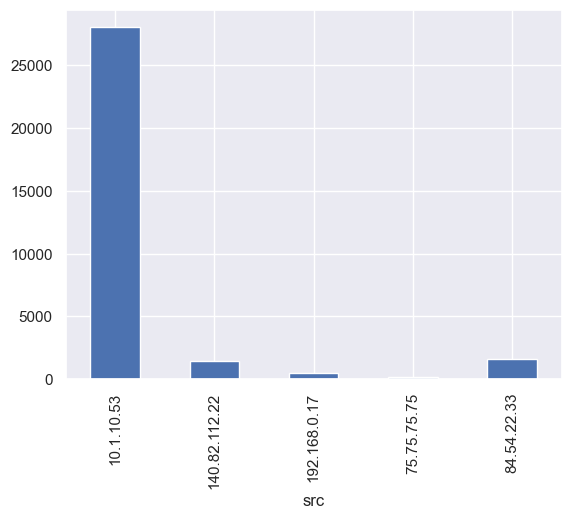

In [21]:
# graph a 2D graph where y axis are IPs org and x axis is the sum of payloads sent to each IP
df.groupby('src')['payload'].sum().plot(kind='bar')

Muestre una gráfica 2D, en el eje Y las IPs destino, y en el eje X la suma de los payloads recibidos en dichas direcciones.

<AxesSubplot:xlabel='dst'>

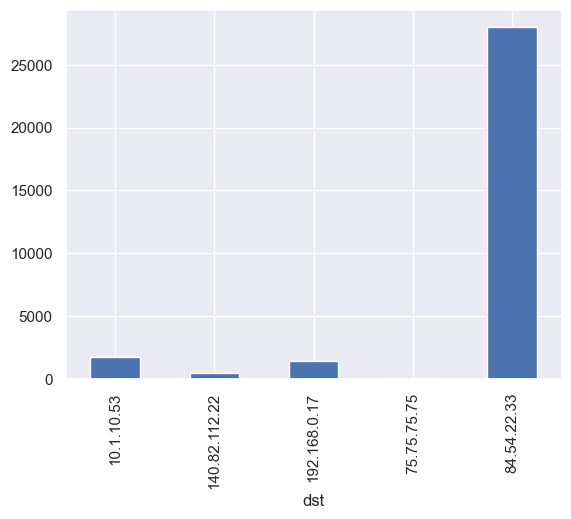

In [22]:
df.groupby('dst')['payload'].sum().plot(kind='bar')

Muestre una gráfica 2D, en el eje Y los puertos origen, y en el eje X la suma de los payloads enviados de dichos puertos.

<AxesSubplot:xlabel='sport'>

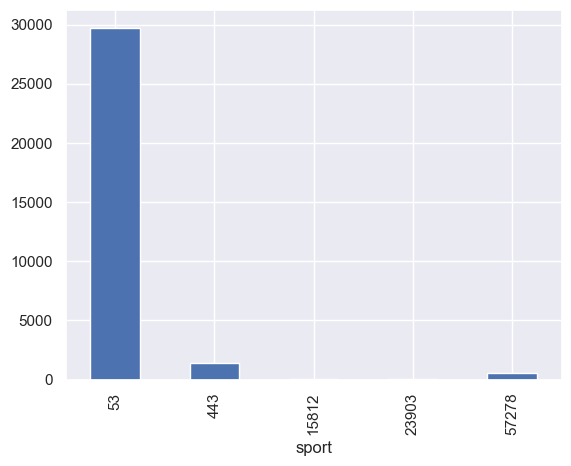

In [23]:
df.groupby('sport')['payload'].sum().plot(kind='bar')

Muestre una gráfica 2D, en el eje Y los puertos destino, y en el eje X la suma de los payloads recibidos en dichos puertos

<AxesSubplot:xlabel='dport'>

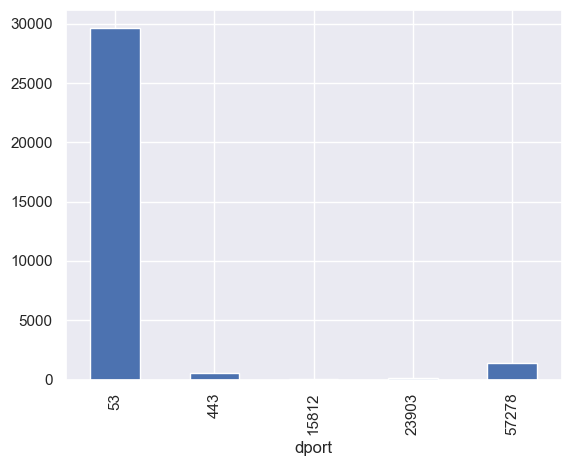

In [24]:
df.groupby('dport')['payload'].sum().plot(kind='bar')

#### Investigación del payload

In [28]:
df2 = df['src'] == '10.1.10.53'
df2 = df[df2]

# reset index
df2 = df2.reset_index()

In [29]:
df2 = df2.drop(columns="index")

In [35]:
# group by payload 
df2.groupby('src')['payload'].sum()

src
10.1.10.53    28053
Name: payload, dtype: object